In [1]:
import os.path

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
import sys, os

from Bio import SeqIO
import Bio.PDB, warnings
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
from Bio import pairwise2

pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_new
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [2]:
data_path = Path('/home', 'eclay','Pfam-A.full')
data_path = Path('Pfam-A.full')
DCA_ER_dir = Path('/home/evan/PycharmProjects/DCA_ER/')



pfam_id = 'PF00023'
pfam_id = 'PF00011'
pfam_id = 'PF14525'
pfam_id = 'PF03678'
pfam_id = 'PF00186'
pfam_id = 'PF03496'


n_jobs = 6
create_new = True
removing_cols = True
printing=True


DCA_ER_dir = '/data/cresswellclayec/DCA_ER/'
msa_npy_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.npy' % pfam_id
msa_fa_file  = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/msa.fa' % pfam_id
pdb_ref_file = '/data/cresswellclayec/DCA_ER/Pfam-A.full/%s/pdb_refs.npy' % pfam_id
out_dir = '%sprotein_data/di/' % DCA_ER_dir
processed_data_dir = '%sprotein_data/data_processing_output' % DCA_ER_dir

# Define data directories
# Need to think on best way to do this..
# Referencing the same dataframe may be useful so we dont always have to load individual ref files...
# however we also
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_ER_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
print(pdb_df.head())
pdb_reference_ids = np.unique(pdb_df['pdb_id'].to_numpy())
print('PDB reference IDs:\n', pdb_reference_ids)

number of pdb structures: 2
        PF  seq            id uniprot_start uniprot_end pdb_id chain  \
0  PF03496  445  Q88A91_PSESM           108         258   3U0J     B   
1  PF03496  445  Q88A91_PSESM           108         258   3U0J     A   

  pdb_start pdb_end  
0       108     258  
1       108     258  
PDB reference IDs:
 ['3U0J']


## Test Run of PDB-matching sequence from given MSA

In [3]:
# ipdb = 0
# printing = True
# print('seq:',int(pdb[ipdb,1]))

# start_time = timeit.default_timer()
# pdb_matches= tools.find_best_pdb(pfam_id, data_path, create_new=create_new)
# run_time = timeit.default_timer() - start_time

# print('finding best match takes %f seconds ' % run_time)



# index_pdb = 0
# pdb_select = pdb_matches.iloc[index_pdb]

# # enforce old PDB refs structure for PF00186
# pdb_select = pdb_matches.loc[pdb_matches['MSA Index']==69].iloc[0]

# query_seq = pdb_select['Query Aligned Seq']
# subject_seq = pdb_select['Subject Aligned Seq']
# mismatch_cols = [i for i,a in enumerate(query_seq) if a != subject_seq[i]]

# print(query_seq)
# print('Selected PDB: \n', pdb_select)

# print('\n\nMismatching Columns between query and subject: ', mismatch_cols)


In [4]:
individual_pdb_ref_file = Path(data_path, pfam_id, 'pdb_refs.npy')
pdb = np.load(individual_pdb_ref_file)
processed_data_dir = "%s/protein_data/data_processing_output" % DCA_ER_dir

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])


# Print number of pdb structures in Protein ID folder
npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

# Create pandas dataframe for protein structure
pdb_df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_end',\
                                 'pdb_id','chain','pdb_start','pdb_end'])


number of pdb structures: 2


## New Data Processing and Contact Mapping

In [5]:
s0, removed_cols, s_index, tpdb, pdb_select \
= data_processing_new(data_path, pfam_id, index_pdb=0,gap_seqs=0.2, gap_cols=0.2, prob_low=0.004, 
                        conserved_cols=0.8, printing=True, out_dir='./', letter_format=False, 
                        remove_cols=removing_cols, create_new=create_new)


pdb_chain, ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range, poly_seq, pp_ca_coords_curated, pp_ca_coords_full_range \
= tools.contact_map_new(pdb_id=pdb_select['PDB ID'][:4], pdb_range=[pdb_select['Subject Beg'], pdb_select['Subject End']], \
                  removed_cols=removed_cols, queried_seq=pdb_select['Subject Aligned Seq'],  pdb_out_dir=processed_data_dir)

Original Sequence length:  912
#

--------------------- Find Matching PDB Strucutre for MSA ----#
Finding best PDB match for (Searching 469 sequences) PF03496
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
bad query
b

Found Match!

TPLYREVNNYLRLQHENSGREAEIDNHDEKLSPHIKMLSSALNRLMDVAAFRGTVYRGIRGDLDTIARLYHLFDTGGRYVEPAFMSTTRIKDSAQVFEPGTPNNIAFQISLKRGADISGSSQAPSEEEIMLPMMSEFVIEHASALSEGKHL
TPLYREVNNYLRLQHENSGREAEIDNHDEKLSPHIKMLSSALNRLMDVAAFRGTVYRGIRGDLDTIARLYHLFDTGGRYVEPAFMSTTRIKDSAQVFEPGTPNNIAFQISLKRGADISGSSQAPSEEEIMLPMMSEFVIEHASALSEGKHL


B
(107, 107)
MSA Index                                                            445
PDB ID                                                            3U0J_1
Score                                                                1.0
Identity                                                             1.0
E-value                                                              0.0
Bitscore                                                             305
Alignment Length                                                     151
Mismatches                                                             0
Gaps Opened                                                            0
Query Beg                                                              1
Query End                                                            151
Subject Beg                                                          114
Subject End                                                          264
Query Len                             

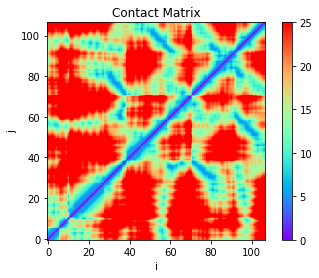

In [26]:
print(pdb_chain)
ct_mat = ct
print(ct_mat.shape)
print(pdb_select)
# tools.hide_toggle()
print('Contact matrix shape:', ct_mat.shape)

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.title('Contact Matrix')
plt.imshow(ct_mat,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,25)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()

In [7]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 107
Number of sequences: 367
Number of different amino acids at each position [11 19 19 10 18 19 18 17 19 19 19 19 19 17 20 18 19 14 18 20  8 12 14 12
  7 18 18 20 16 16 17 17 16 17 19 12 18 16 16 19 20 19 19 20 20 19 19 20
 15 11 18 18 16 18 16 17 13  8 11  8  6 15 19 18 18 19 20 18 20 20 19 20
 21 16 20  9 20 15 19 17 15 17 19 13 17 18 17 16 19 20 19 20 17  9  4  8
 15 17 13 16 19  9 18  9 14 12 13]
Total number of variables 1737


In [8]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
# print("Amino Acid sequence Matrix\n",s0)
# print("OneHot sequence Matrix\n",s)
# print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

In [9]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

In [10]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [11]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1


# if os.path.exists("%s_w_new.npy" % pfam_id) and not create_new:
if 0:
    w = np.load("%s_w_new.npy" % pfam_id)
else:
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.



/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 52.214800416491926


In [12]:
# Verify that w is symmetric (sanity test)
print("Dimensions of w: ",w.shape)
w_file = "%s_w_new.npy" % pfam_id
np.save(w_file, w)

Dimensions of w:  (1737, 1737)


In [13]:
di = direct_info(s0,w)
print(di)
print(di.shape)
print(len(s_index))

[[0.         0.00203203 0.00170783 ... 0.0011214  0.00095673 0.00155011]
 [0.00203203 0.         0.00112108 ... 0.00093748 0.00122471 0.00091176]
 [0.00170783 0.00112108 0.         ... 0.00093949 0.00076317 0.0012941 ]
 ...
 [0.0011214  0.00093748 0.00093949 ... 0.         0.00594597 0.00428448]
 [0.00095673 0.00122471 0.00076317 ... 0.00594597 0.         0.00933618]
 [0.00155011 0.00091176 0.0012941  ... 0.00428448 0.00933618 0.        ]]
(107, 107)
107


## Run ER

ER DI shape:  (107, 107)
[  0   1   2   7  10  11  12  13 142 143 144 145  18  19  20  21  22 146
  24  25  26  27 147 148 149 150  45  46  56  59  60  61  62  63  71  85
  92  93 100 101 102 103 125 127]
Final ER DI shape (cols removed):  (107, 107)


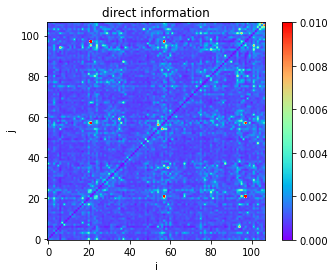

In [14]:
#print("Direct Information from Expectation reflection:\n",di)
print('ER DI shape: ' , di.shape)
print(removed_cols)
if not removing_cols:
    ER_di = np.delete(di, removed_cols,0)
    ER_di = np.delete(ER_di, removed_cols,1)
else:
    ER_di = di

print('Final ER DI shape (cols removed): ', ER_di.shape)

# print("Direct Information from Expectation reflection:\n",di)
def no_diag(mat, diag_l, s_index=None, make_big=False):
    rows, columns = mat.shape
    if make_big:
        new_mat = 100. * np.ones((rows,columns))
    else:
        new_mat = np.zeros((rows,columns))
    for row in range(rows):
        for col in range(columns):
            if s_index is None:
                if abs(row-col) > diag_l:
                    new_mat[row, col] = mat[row ,col]
            else:
                if abs(s_index[row]-s_index[col]) > diag_l:
                    new_mat[row, col] = mat[row ,col]    
    return new_mat

ER_di_nodiag = no_diag(ER_di, 5, s_index)

plt.title('direct information')
plt.imshow(ER_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()




ER auc max: 4.352941176470588 0.7510327837715283

Contact threshold:  4.352941176470588


Text(0, 0.5, 'Precision (PPV)')

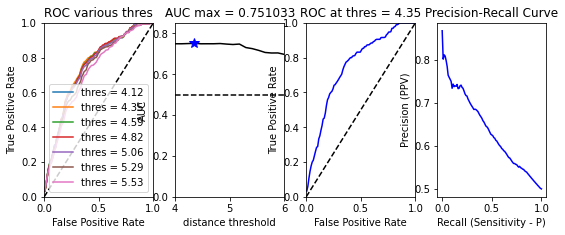

In [15]:
from ecc_tools import roc_curve
# find optimal threshold of distance
ct_thres = np.linspace(4.,6.,18,endpoint=True)
n = ct_thres.shape[0]


# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# Find ct_threshold (2-6 Angstrom) which gives best contact prediction for ER
auc_ER = np.zeros(n)
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, ER_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_ER[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_ER[i] = 0

# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
p0_ER,tp0_ER,fp0_ER = tools.roc_curve(ct_mat,ER_di,ct_thres[i0_ER])

# ROC-curve tile settings
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


# Plot ROC, AUC and Precision for best ER contact prediction
# AUC
plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'k-')
plt.plot(ct_thres[i0_ER],auc_ER[i0_ER], 'b*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_ER.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
# ROC
plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Precision-Recall
plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
print('\nContact threshold: ', ct_thres[i0_ER])
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER), 'b-', label='thres = %s'%ct_thres[i0_ER])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

## Run our MF

In [16]:
from inference_dca import direct_info_dca
print(s0.shape)
seq_wt_file = None
seq_wt_file = '%s/protein_data/data_processing_output/seq_weight_%s.npy' % (DCA_ER_dir, pfam_id)

# ----------- DCA DI (MF) calculation --------------------------------------------- #

mf_di, fi, fij, c, cinv, w, w2d, fi_pydca, fij_pydca, c_pydca, c_inv_pydca, \
w_pydca, w2d_pydcak, di_pydca, ma_inv,seq_ints\
= direct_info_dca(s0, seq_wt_outfile=seq_wt_file)
print('c[0]:',c[0])
print('c_pydca[0]', c_pydca[0])

(367, 107)
(367, 107)
ma_inv (sequences weight shape:  (367,)
tais meff = 338.350000
meff for our MF =  338.35
(107, 21)
(107, 21)
(5671, 20, 20)
2140
c[0]: [ 4.78681114e-02 -1.34920438e-03 -1.57268243e-03 ... -3.55917451e-03
 -6.64321687e-05 -4.38895585e-04]
c_pydca[0] [ 0.02604868 -0.00083502 -0.00063726 ...  0.0049298   0.00029876
 -0.00152064]


(107, 107)


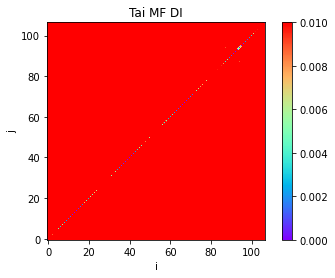

In [17]:
if not removing_cols:
    MF_di = np.delete(mf_di, cols_removed,0)
    MF_di = np.delete(MF_di, cols_removed,1)
else:
    MF_di = mf_di
# --------------------------------------------------------------------------------- #
print(MF_di.shape)
plt.title('Tai MF DI')
plt.imshow(MF_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0.,.01)
plt.colorbar(fraction=0.045, pad=0.05)


auc max: 4.0 0.7536610211875678


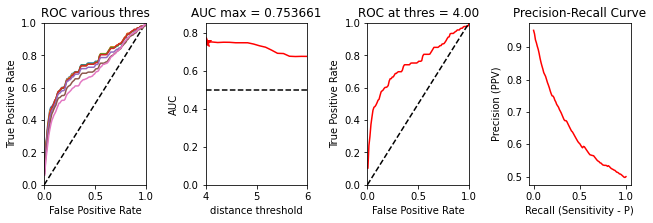

In [18]:
# Run our version of MF di scores through Average Product Correction (to combat influences of phylogeny)
# mf_APC = score_APC(MF_di, sequence_length, s_index)
# MF_di = tools.di_dict2mat(mf_APC, cols_removed, s_index)

# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

# find optimal threshold of distance
auc_MF = np.zeros(n)

for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, MF_di, ct_thres[i])
        if i in iplot:
            plt.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
        
i0_MF = np.argmax(auc_MF)
print('auc max:',ct_thres[i0_MF],auc_MF[i0_MF])
p0_MF,tp0_MF,fp0_MF = tools.roc_curve(ct,MF_di,ct_thres[i0_MF])


plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_MF[i0_MF]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_MF,'r-')
plt.plot(ct_thres[i0_MF],auc_MF[i0_MF], 'r*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_MF.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_MF]))
plt.plot(fp0_MF,tp0_MF,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
plt.plot(p0_MF, tp0_MF / (tp0_MF + fp0_MF), 'r-', label='thres = %s'%ct_thres[i0_MF])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

plt.tight_layout(h_pad=1, w_pad=1.5)

In [23]:
method = 'DI'
# Load pydca score pseudo-dictionaries and generate di matrices from them..
plm_score_file = '%s%s_%s_pydca_plm.npy' % (out_dir, pfam_id, method)
mf_score_file = '%s%s_%s_pydca_mf.npy' % (out_dir, pfam_id, method)
# mf_score_file = '%s%s_%s_pydca_mf_di.npy' % (out_dir, pfam_id, method)
# plm_score_file = '%s%s_%s_pydca_plm_di.npy' % (out_dir, pfam_id, method)  

# list of di scores length of: seq_len choose 2 
# (ie for PF00186 with sequence length 160, this should be length 160 choose 2 = 12720)
mf_scores = np.load(mf_score_file, allow_pickle=True)
plm_scores = np.load(plm_score_file, allow_pickle=True)

                                                                           
def di_dict2mat(pydca_score, s_index, curated_cols = None, full_contact=False, aa_index_correction=True, removing_cols=False):
    # This functions converts the dictionary (with 2 int index tuple as keys) of pydca scores to a di matrix which
    #   incorporates the removed columns during pre-processing (cols_removed) resulting in a pydca di matrix with
    #   correct dimensions
    #for pair, score in pydca_score:                                                                     
    #    print(pair, score)

    if full_contact:
        column_count = len(s_index) + len(cols_removed)                                                  
    else:
        column_count = len(s_index)                                                                      
    
    pydca_di = np.zeros((column_count, column_count))
    # ijs = []                                                                                           
    for [(i, j), score] in pydca_score:                                                                  
        # ijs.append(i)                                                                                  
        # ijs.append(j)
        if aa_index_correction:                                                                          
            if removing_cols:
                if i-1 in s_index and j-1 in s_index:
                    ii = np.where(s_index==i-1)[0][0]                                                        
                    jj = np.where(s_index==j-1)[0][0]  
                    pydca_di[ii, jj] = score                                                                 
                    pydca_di[jj, ii] = score                                                                 
            else:
                pydca_di[i-1, j-1] = score
                pydca_di[j-1, i-1] = score                                                               
                
        else:
            pydca_di[i, j] = score 
            pydca_di[j, i] = score 
                                                                                                         
    # print('max index: ', max(ijs))                                                                     
    print('DI shape (full size)' , pydca_di.shape)
    if curated_cols is not None and not removing_cols:   # have we curated (set to gap instead of removed) 
                                                        # but not removed columns?
        # trim the columns removed during the pre-processing for ER                                      
        pydca_di = np.delete(pydca_di, curated_cols, 0)                                                  
        pydca_di = np.delete(pydca_di, curated_cols, 1)                                                  
    print('DI shape (scores removed)', pydca_di.shape,'\n(should be same as ER di shape..)')             
        
    return pydca_di


pydca_MF_di = di_dict2mat(mf_scores, s_index, curated_cols=removed_cols, aa_index_correction=True, removing_cols = removing_cols)
pydca_PLM_di = di_dict2mat(plm_scores, s_index, curated_cols=removed_cols, aa_index_correction=True, removing_cols = removing_cols)


DI shape (full size) (107, 107)
DI shape (scores removed) (107, 107) 
(should be same as ER di shape..)
DI shape (full size) (107, 107)
DI shape (scores removed) (107, 107) 
(should be same as ER di shape..)


auc max: 4.0 0.9048977537820021
auc max: 4.588235294117647 0.7601315954326859


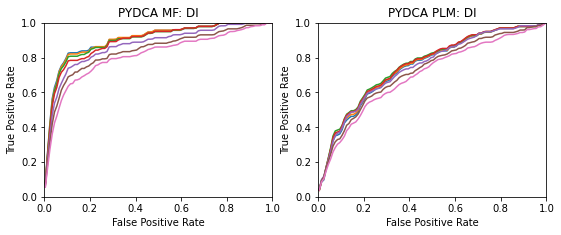

In [24]:
# which contact matrix do you want to use (full or curated)
ct_mat = ct_full # full pdb contact matrix without columns removed
ct_mat = ct  # full pdb contact matrix with conserved and bad columns removed (defined during pre-processing)
plt.figure(figsize=(9.0,3.2))

plt.title('ROC for PYDCA scores')

# PYDCA-MF
auc_pydca_MF = np.zeros(n)

ax1 = plt.subplot2grid((1,2),(0,0))
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, pydca_MF_di, ct_thres[i])
        if i in iplot:
            ax1.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_pydca_MF[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_MF[i] = 0
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('PYDCA MF: %s' % method)
        
i0_pydca_MF = np.argmax(auc_pydca_MF)
print('auc max:',ct_thres[i0_pydca_MF],auc_pydca_MF[i0_pydca_MF])
p0_pydca_MF,tp0_pydca_MF,fp0_pydca_MF = tools.roc_curve(ct_mat,pydca_MF_di,ct_thres[i0_pydca_MF])


# PYDCA-PLM
auc_pydca_PLM = np.zeros(n)

ax2 = plt.subplot2grid((1,2),(0,1))
for i in range(n):
    try:
        p,tp,fp = roc_curve(ct_mat, pydca_PLM_di, ct_thres[i])
        if i in iplot:
            ax2.plot(fp,tp,label='thres = %3.2f'%ct_thres[i])
        auc_pydca_PLM[i] = tp.sum()/tp.shape[0]
    except(RuntimeWarning):
        auc_pydca_PLM[i] = 0
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('PYDCA PLM: %s' %method)
        
i0_pydca_PLM = np.argmax(auc_pydca_PLM)
print('auc max:',ct_thres[i0_pydca_PLM],auc_pydca_PLM[i0_pydca_PLM])
p0_pydca_PLM,tp0_pydca_PLM,fp0_pydca_PLM = tools.roc_curve(ct_mat,pydca_PLM_di,ct_thres[i0_pydca_PLM])

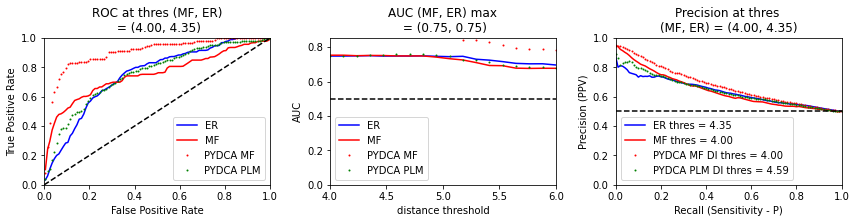

In [25]:
plt.figure(figsize=(12.0,3.2))

# Plot ROC for optimal DCA vs optimal ER
plt.subplot2grid((1,3),(0,0))
plt.title('ROC at thres (MF, ER)\n = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot(fp0_ER,tp0_ER,'b-',label="ER")
plt.plot(fp0_MF,tp0_MF,'r-',label="MF")
plt.plot(fp0_pydca_MF,tp0_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(fp0_pydca_PLM,tp0_pydca_PLM,'go',label="PYDCA PLM", markersize=1)

plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Plot AUC for DCA and ER
plt.subplot2grid((1,3),(0,1))
plt.title('AUC (MF, ER) max\n = (%3.2f, %3.2f)' %(auc_MF[i0_MF], auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'b-',label="ER")
plt.plot(ct_thres,auc_MF,'r-',label="MF")
plt.plot(ct_thres,auc_pydca_MF,'ro',label="PYDCA MF", markersize=1)
plt.plot(ct_thres,auc_pydca_PLM,'go',label="PYDCA PLM", markersize=1)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,max(auc_MF.max(), auc_ER.max())+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
plt.legend()

# Plot Precision of optimal DCA and ER
plt.subplot2grid((1,3),(0,2))
plt.title('Precision at thres \n(MF, ER) = (%3.2f, %3.2f)'%(ct_thres[i0_MF],ct_thres[i0_ER]))
plt.plot( p0_ER,tp0_ER / (tp0_ER + fp0_ER),'b-',label='ER thres = %3.2f'%ct_thres[i0_ER])
plt.plot( p0_MF,tp0_MF / (tp0_MF + fp0_MF),'r-',label='MF thres = %3.2f'%ct_thres[i0_MF])
plt.plot( p0_pydca_MF,tp0_pydca_MF / (tp0_pydca_MF + fp0_pydca_MF),'ro',label='PYDCA MF %s thres = %3.2f' % (method, ct_thres[i0_pydca_MF]), markersize=1)
plt.plot( p0_pydca_PLM,tp0_pydca_PLM / (tp0_pydca_PLM + fp0_pydca_PLM),'go',label='PYDCA PLM %s thres = %3.2f' % (method, ct_thres[i0_pydca_PLM]), markersize=1)

plt.plot([0,1.],[.5,.5],'k--')
plt.xlim([0,1])
plt.ylim([0,1]) 
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')
plt.legend()

plt.tight_layout(h_pad=1, w_pad=1.5)

plt.savefig('ERvPYDCA_%s_comparison.pdf' % method)


# tools.hide_toggle()